In [229]:
import math
import random
import copy


In [230]:
TABLE_SCORE = {
    1: 0,
    2: 4,
    3: 16,
    4: 48,
    5: 128,
    6: 320,
    7: 768,
    8: 1792,
    9: 4096,
    10: 9216,
    11: 20480,
    12: 45056,
    13: 98304
}
MAX_POSSIBLE_SCORE = max(TABLE_SCORE.values())  # = 98304


In [231]:
def get_empty_cells(board):
    """ Return list of (r,c) for all empty cells (where board[r][c]==0). """
    empty = []
    for r in range(4):
        for c in range(4):
            if board[r][c] == 0:
                empty.append((r, c))
    return empty

def spawn_new_tile(board):
    """
    Places a '2' tile (exponent = 1) into a random empty cell.
    """
    empty_cells = get_empty_cells(board)
    if not empty_cells:
        return
    r, c = random.choice(empty_cells)
    board[r][c] = 1  # exponent=1 -> tile 2

def move_left(board):
    """
    Executes 'move left' on a 4x4 board of exponents.
    Returns (new_board, moved) where `moved` indicates if any change occurred.
    """
    moved = False
    new_board = [row[:] for row in board]
    for i in range(4):
        # Merge tiles
        for j in range(3):
            if new_board[i][j] != 0 and new_board[i][j] == new_board[i][j+1]:
                new_board[i][j] += 1
                new_board[i][j+1] = 0
                moved = True
        # Compact to the left
        compressed_row = [x for x in new_board[i] if x != 0]
        compressed_row += [0]*(4 - len(compressed_row))
        if compressed_row != new_board[i]:
            new_board[i] = compressed_row
            moved = True
    return new_board, moved

def move_right(board):
    """ Move right by reversing -> move_left -> reverse back """
    reversed_board = [row[::-1] for row in board]
    tmp_board, moved = move_left(reversed_board)
    new_board = [row[::-1] for row in tmp_board]
    return new_board, moved

def move_up(board):
    """ Move up by transposing -> move_left -> transpose back """
    transposed = [list(x) for x in zip(*board)]
    tmp_board, moved = move_left(transposed)
    new_board = [list(x) for x in zip(*tmp_board)]
    return new_board, moved

def move_down(board):
    """ Move down by transposing -> move_right -> transpose back """
    transposed = [list(x) for x in zip(*board)]
    tmp_board, moved = move_right(transposed)
    new_board = [list(x) for x in zip(*tmp_board)]
    return new_board, moved

def get_legal_moves(board):
    """
    Returns a list of possible moves (0=UP, 1=RIGHT, 2=DOWN, 3=LEFT) that change the board.
    """
    moves = []
    for move_id in range(4):
        if move_id == 0:
            new_b, changed = move_up(board)
        elif move_id == 1:
            new_b, changed = move_right(board)
        elif move_id == 2:
            new_b, changed = move_down(board)
        else:
            new_b, changed = move_left(board)
        if changed:
            moves.append(move_id)
    return moves

def apply_move(board, move_id):
    """
    Applies the move (0=UP, 1=RIGHT, 2=DOWN, 3=LEFT) to the board, then spawns a tile.
    Returns the resulting board or None if no change was possible.
    """
    if move_id == 0:
        new_b, changed = move_up(board)
    elif move_id == 1:
        new_b, changed = move_right(board)
    elif move_id == 2:
        new_b, changed = move_down(board)
    else:
        new_b, changed = move_left(board)
    if not changed:
        return None
    spawn_new_tile(new_b)
    return new_b

def is_game_over(board):
    """ True if no moves remain. """
    return len(get_legal_moves(board)) == 0

def compute_score(board):
    """
    Summation of TABLE_SCORE[tile_exponent].
    """
    s = 0
    for r in range(4):
        for c in range(4):
            val = board[r][c]
            s += TABLE_SCORE.get(val, 0)
    return s

In [232]:
class MCTSNode:
    def __init__(self, board, parent=None, move_from_parent=None):
        self.board = board
        self.parent = parent
        self.move_from_parent = move_from_parent
        
        self.children = []
        self.untried_moves = get_legal_moves(self.board)
        
        self.visits = 0
        self.total_value = 0.0  # sum of final scores

    def is_fully_expanded(self):
        return len(self.untried_moves) == 0

    def best_child(self, c=1.41):
        """
        Uses UCB1 with normalized average:
          normalized_avg = (average_score / MAX_POSSIBLE_SCORE)
          where average_score = (child.total_value / child.visits)
        """
        best = None
        best_ucb = float('-inf')

        for child in self.children:
            if child.visits == 0:
                # If a child was never visited, pick it to avoid division by zero
                return child

            # 2) Normalized average child value
            avg_score = (child.total_value / child.visits)
            normalized_avg = avg_score / MAX_POSSIBLE_SCORE

            # 3) UCB = normalized_avg + c * sqrt(2 ln(N) / n_i)
            exploit_term = normalized_avg
            explore_term = c * math.sqrt((2.0 * math.log(self.visits)) / child.visits)

            ucb = exploit_term + explore_term

            if ucb > best_ucb:
                best_ucb = ucb
                best = child

        return best

    def add_child(self, move_id, board_after_move):
        child_node = MCTSNode(board_after_move, parent=self, move_from_parent=move_id)
        self.children.append(child_node)
        self.untried_moves.remove(move_id)
        return child_node

    def update(self, value):
        self.visits += 1
        self.total_value += value

In [233]:
from graphviz import Digraph

def visualize_tree(root, max_nodes=4000):
    """
    Visualize the MCTS tree structure in a layer-by-layer fashion using graphviz.
    Each layer is limited to at most 16 nodes (based on the best metric).
    
    The 'best' 16 children are chosen by descending (total_value / visits).
    If visits=0, we treat the metric as 0.0.
    
    Args:
        root: The root MCTSNode of the tree.
        max_nodes: Maximum number of total nodes to include (prevents overload).
    """
    dot = Digraph(comment="MCTS Tree")

    # For easy node labeling in the graph
    def make_label(node):
        label = f"Visits: {node.visits}\nValue: {node.total_value / node.visits:.2f}"
        if node.move_from_parent is not None:
            label += f"\nMove: {node.move_from_parent}"
        return label

    # Assign the root an ID and add it to the graph
    node_id_map = {}
    node_id_map[root] = 0
    dot.node("0", label=make_label(root))

    # 'current_layer' will be a list of nodes for the current depth
    current_layer = [root]
    layer = 0

    # We'll continue until we run out of layers or exceed max_nodes
    while current_layer and len(node_id_map) < max_nodes:
        next_layer_candidates = []
        
        # Gather all children for the entire layer
        for node in current_layer:
            # Collect the children of this node
            for child in node.children:
                # If we've reached max capacity, break
                if len(node_id_map) >= max_nodes:
                    break

                # If the child isn't already in the map (not yet visualized),
                # prepare it as a candidate for the next layer.
                if child not in node_id_map:
                    # Compute the metric (total_value / visits)
                    if child.visits > 0:
                        metric = child.total_value / child.visits
                    else:
                        metric = 0.0  # or skip it entirely

                    parent_id = node_id_map[node]
                    next_layer_candidates.append((child, parent_id, metric))
        
        # We have now gathered all candidates for the next layer
        if not next_layer_candidates:
            break

        # Sort descending by metric and take the top 16
        next_layer_candidates.sort(key=lambda x: x[2], reverse=True)
        next_layer_candidates = next_layer_candidates[:16]

        # Now we create the new layer from the chosen candidates
        next_layer = []
        for child, parent_id, metric in next_layer_candidates:
            if child not in node_id_map:
                new_id = len(node_id_map)
                node_id_map[child] = new_id
                dot.node(str(new_id), label=make_label(child))
                dot.edge(str(parent_id), str(new_id))
                next_layer.append(child)
            else:
                # The child was already in the map (rare in a pure tree),
                # but if it happens, just ensure we connect the edge
                # if it's not yet connected.
                child_id = node_id_map[child]
                dot.edge(str(parent_id), str(child_id))
        
        # Move to the next layer
        current_layer = next_layer
        layer += 1

    return dot


In [234]:
def tree_policy(node):
    """
    Selection + expansion:
      - If node not fully expanded, expand
      - Else descend to best child
      - Stop if terminal
    """
    while not is_game_over(node.board):
        if not node.is_fully_expanded():
            return expand(node)
        else:
            node = node.best_child()  # Use UCB1 for selection
    return node

def expand(node):
    """Expand by creating one child for an untried move."""
    move_id = random.choice(node.untried_moves)
    new_board = apply_move(node.board, move_id)
    # If for some reason the move can't be applied, remove from untried_moves
    if new_board is None:
        node.untried_moves.remove(move_id)
        return node
    return node.add_child(move_id, new_board)

def default_policy(board):
    """Play random moves until the game ends. Return final score."""
    sim_board = copy.deepcopy(board)
    while not is_game_over(sim_board):
        moves = get_legal_moves(sim_board)
        if not moves:
            break
        move_id = random.choice(moves)
        sim_board = apply_move(sim_board, move_id)
        if sim_board is None:
            break
    return compute_score(sim_board)

def backup(node, value):
    """Propagate the simulation result up the tree."""
    current = node
    while current is not None:
        current.update(value)
        current = current.parent

def mcts(root_board, iterations=1000, c=1.41):
    """
    Run MCTS from the given board state for 'iterations' iterations.
    Return the best move from the root.
    """
    root_node = MCTSNode(board=root_board)

    for _ in range(iterations):
        # 1) Selection + expansion
        leaf = tree_policy(root_node)
        # 2) Simulation
        sim_result = default_policy(leaf.board)
        # 3) Backprop
        backup(leaf, sim_result)
    
    # Final move from root: use best_child with the same 'c' or c=0 for pure exploitation
    best_child_node = root_node.best_child(c=c)
    tree_visualization = visualize_tree(root_node, max_nodes=2000)
    tree_visualization.render("mcts_tree", format="png", cleanup=True)  # Saves as 'mcts_tree.png'
    tree_visualization
    return best_child_node.move_from_parent

In [237]:
board = [[0]*4 for _ in range(4)]
spawn_new_tile(board)
spawn_new_tile(board)

print("Initial Board:")
for row in board:
    print(row)

# Run MCTS for some iterations
recommended_move = mcts(board, iterations=10000)

move_map = {0: "UP", 1: "RIGHT", 2: "DOWN", 3: "LEFT"}
print(f"\nMCTS recommends: {move_map.get(recommended_move, 'UNKNOWN')}")

Initial Board:
[0, 0, 0, 0]
[0, 0, 0, 0]
[1, 0, 0, 0]
[1, 0, 0, 0]

MCTS recommends: DOWN


In [4]:
import numpy as np
board_1d = np.loadtxt('/home/zeffar/Github/2048/decision_tree/mcts_cuda/state.txt', dtype=np.int32).flatten()
    

print("Initial board (1D):", *board_1d)

Initial board (1D): 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0


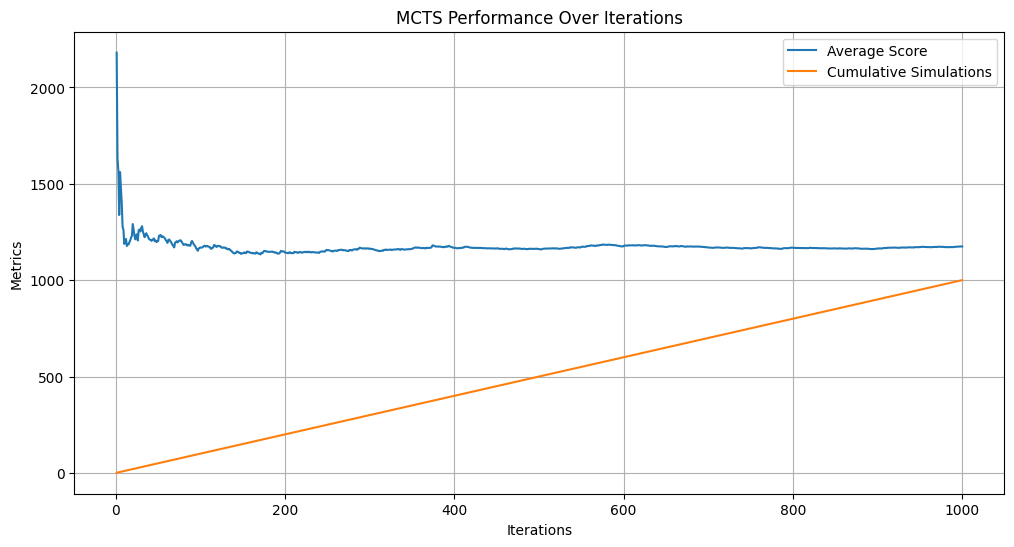

In [236]:
import matplotlib.pyplot as plt

def track_mcts_performance(root_board, iterations=1000):
    """
    Tracks the performance of MCTS over iterations and visualizes it.
    
    Args:
        root_board: The starting board for MCTS.
        iterations: Number of MCTS iterations to run.
    
    Returns:
        A plot of average score and cumulative simulations over iterations.
    """
    root_node = MCTSNode(board=root_board)
    avg_scores = []
    simulation_counts = []

    for i in range(iterations):
        leaf = tree_policy(root_node)
        value = default_policy(leaf.board)
        backup(leaf, value)

        # Track average score and total simulations
        total_value = sum(child.total_value for child in root_node.children)
        total_visits = sum(child.visits for child in root_node.children)
        avg_score = total_value / total_visits if total_visits > 0 else 0
        avg_scores.append(avg_score)
        simulation_counts.append(total_visits)

    # Plotting results
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, iterations + 1), avg_scores, label="Average Score")
    plt.plot(range(1, iterations + 1), simulation_counts, label="Cumulative Simulations")
    plt.xlabel("Iterations")
    plt.ylabel("Metrics")
    plt.title("MCTS Performance Over Iterations")
    plt.legend()
    plt.grid()
    plt.show()

# Usage:
# Assuming `board` is the starting board:
track_mcts_performance(board, iterations=1000)
